In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima.arima import auto_arima
import emd
from matplotlib import rcParams

In [3]:
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [4]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
target_column = 'T (degC)'
target_index = 'datetime'
load = df[target_column]
time = df[target_index]
x_label = 'Time'
y_label = 'Temperature (°C)'

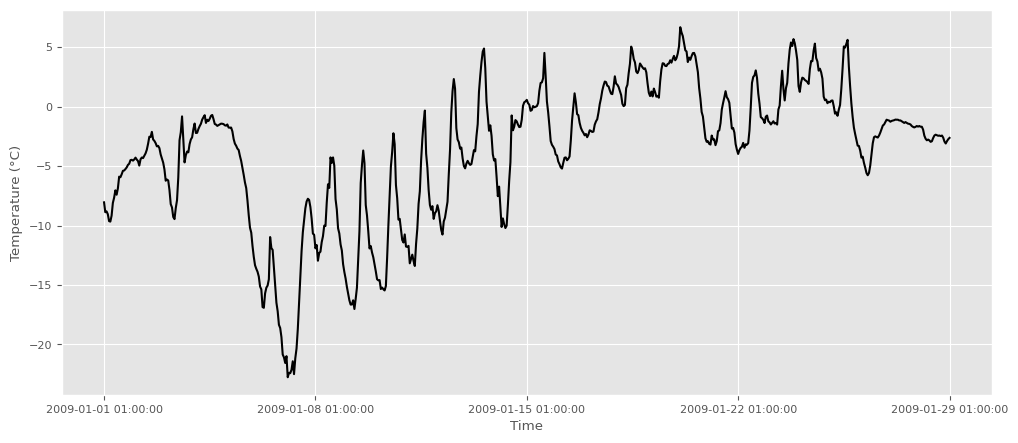

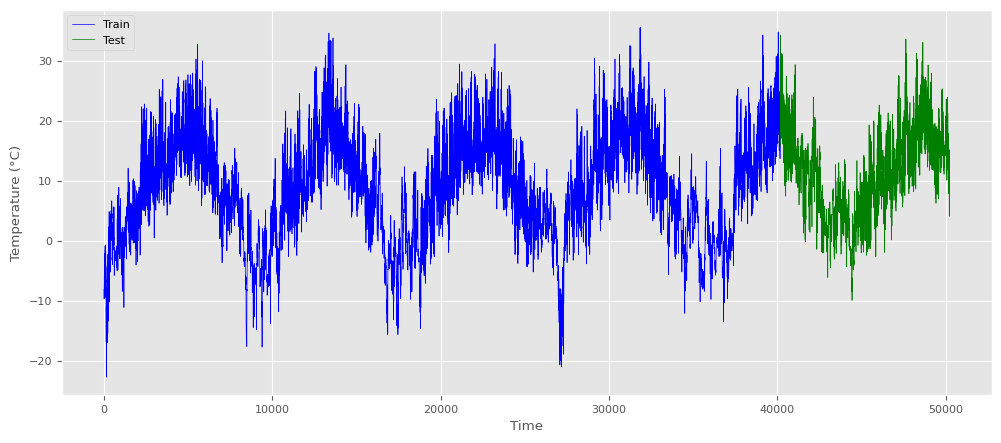

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


In [5]:
plt.plot(time[:673], load[:673], color='k', label='Real')
plt.xticks(np.arange(0, 673, step=168))
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.show()

# Separar en train y test
train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]
plt.plot(train, label='Train', color='b', linewidth=0.5)
plt.plot(test, label='Test', color='g', linewidth=0.5)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

# Crear DataFrames de entrenamiento y prueba con retardos
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
for i in range(1, 4):
    df_train["lag{}".format(i)] = df_train[target_column].shift(i)
    df_test["lag{}".format(i)] = df_test[target_column].shift(i)

df_train = df_train.bfill().drop(columns=[target_column])
df_test = df_test.bfill().drop(columns=[target_column])
display(df_train, df_test)

<Axes: xlabel='Time (samples)'>

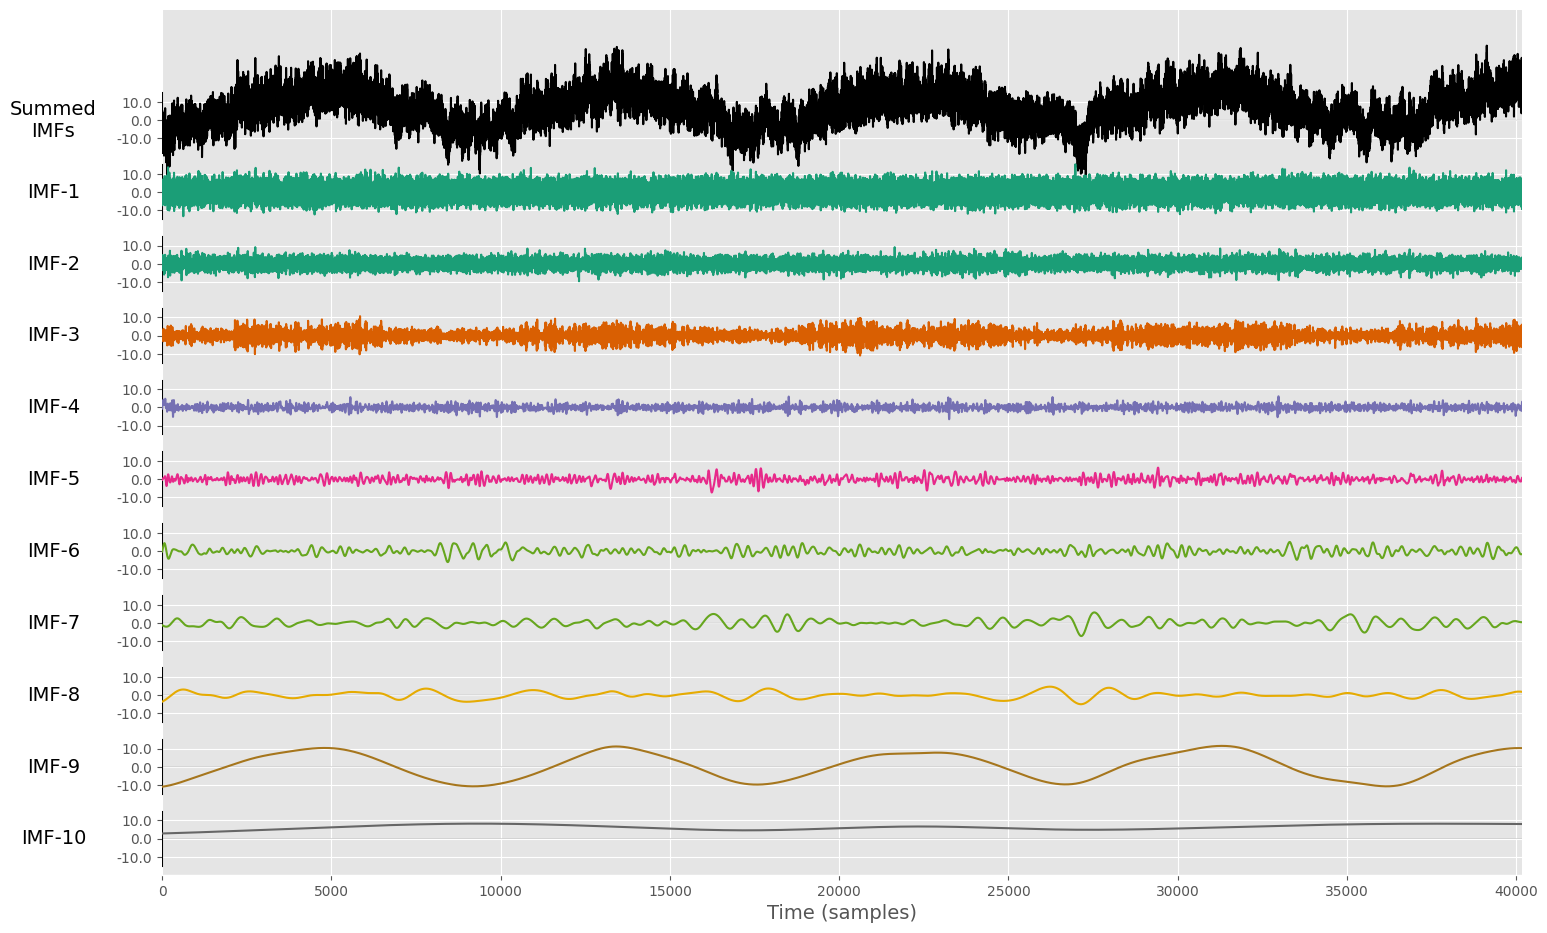

In [6]:
# Aplicar EEMD (Empirical Mode Decomposition)
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [11]:
# Crear un DataFrame con los IMF
imf_eemd_df = pd.DataFrame(data=imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,2.876543,-2.876431,1.329793,-0.606294,-0.233807,-0.171152,-1.195875,-3.724112,-10.976694,2.831244
1,-2.469303,0.049632,1.320657,-0.536233,-0.206420,-0.093583,-1.207442,-3.715812,-10.974427,2.831780
2,2.056707,3.527465,1.087495,-0.383118,-0.171392,-0.014302,-1.218944,-3.707456,-10.972149,2.832316
3,-0.819461,4.017966,0.556226,-0.153235,-0.130096,0.066596,-1.230380,-3.699045,-10.969862,2.832851
4,-7.367409,2.184972,-0.134959,0.139867,-0.083670,0.149017,-1.241750,-3.690579,-10.967564,2.833388
...,...,...,...,...,...,...,...,...,...,...
40174,-3.005988,-0.892259,-5.139056,3.019304,0.943282,-1.583082,0.475033,1.706224,10.247154,8.040922
40175,6.908737,-0.773022,-5.941081,3.114100,0.949161,-1.580275,0.476810,1.703637,10.246432,8.040820
40176,-2.075676,-1.025714,-6.366494,3.168152,0.946039,-1.577898,0.478693,1.701025,10.245704,8.040718
40177,-9.514957,-1.546044,-6.387646,3.179646,0.933695,-1.575932,0.480683,1.698388,10.244970,8.040616


In [12]:
from statsmodels.tsa.arima.model import ARIMA

imf1_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_1'], order=(2, 1, 5)).fit()
imf1_eemd_arima_fc = imf1_eemd_arima.forecast(steps=len(test))

imf2_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_2'], order=(2, 1, 5)).fit()
imf2_eemd_arima_fc = imf2_eemd_arima.forecast(steps=len(test))

imf3_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_3'], order=(2, 1, 5)).fit()
imf3_eemd_arima_fc = imf3_eemd_arima.forecast(steps=len(test))

imf4_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_4'], order=(2, 1, 5)).fit()
imf4_eemd_arima_fc = imf4_eemd_arima.forecast(steps=len(test))

imf5_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_5'], order=(2, 1, 5)).fit()
imf5_eemd_arima_fc = imf5_eemd_arima.forecast(steps=len(test))

imf6_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_6'], order=(2, 1, 5)).fit()
imf6_eemd_arima_fc = imf6_eemd_arima.forecast(steps=len(test))

imf7_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_7'], order=(2, 1, 5)).fit()
imf7_eemd_arima_fc = imf7_eemd_arima.forecast(steps=len(test))

imf8_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_8'], order=(2, 1, 5)).fit()
imf8_eemd_arima_fc = imf8_eemd_arima.forecast(steps=len(test))

imf9_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_9'], order=(2, 1, 5)).fit()
imf9_eemd_arima_fc = imf9_eemd_arima.forecast(steps=len(test))

imf10_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_10'], order=(2, 1, 5)).fit()
imf10_eemd_arima_fc = imf10_eemd_arima.forecast(steps=len(test))

# arima = ARIMA(train, order=(2, 1, 5)).fit()
# imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
# imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

# imf2_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf2_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_2'])
# imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_test))

# imf3_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf3_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_3'])
# imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_test))

# imf4_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf4_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
# imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_test))

# imf5_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf5_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
# imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_test))

# imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
# imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

# imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
# imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

# imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
# imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

# imf9_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf9_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_9'])
# imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_test))

# imf10_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf10_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_10'])
# imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_test))

# # imf11_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# # imf11_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_11'])
# imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\stat

In [13]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

In [14]:
imf_eemd_fc = np.sum([imf1_eemd_arima_fc, imf2_eemd_arima_fc, imf3_eemd_arima_fc,
                imf4_eemd_arima_fc, imf5_eemd_arima_fc,imf6_eemd_arima_fc,
                imf7_eemd_arima_fc,imf8_eemd_arima_fc,imf9_eemd_arima_fc, imf10_eemd_arima_fc], axis = 0)

In [16]:
imf_eemd_fc.shape

(10045,)

In [17]:
test.values.shape

(10045,)

In [18]:
imf_eemd_fc

array([17.18479301, 18.27476   , 20.39813578, ...,  0.81223541,
        0.81074046,  0.80926885])

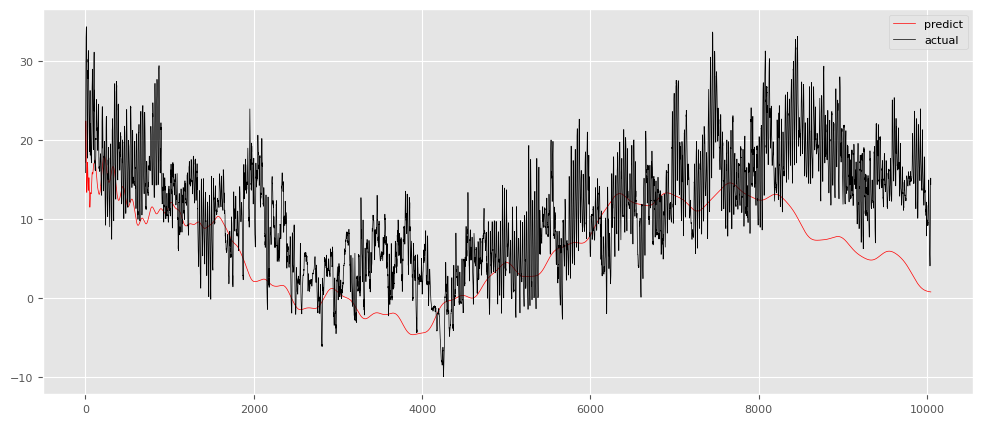

RMSE = 56.430803401003004 
MAE = 6.0459283627402 
MAPE = 3214960240094.753


In [19]:
plt.plot(imf_eemd_fc,label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test.values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.savefig('EEMDSVR')
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [8]:
# Listas para almacenar modelos y predicciones
imf_arima_models = []
imf_arima_forecasts = []

# Entrenar AutoARIMA para cada IMF
for i in range(imf_eemd.shape[1]):
    imf_series = imf_eemd_df['imf_eemd_{}'.format(i+1)]
    
    # Ajustar el modelo AutoARIMA
    auto_arima_model = auto_arima(imf_series,
                                  start_p=1, start_q=1,
                                  max_p=3, max_q=3,
                                  seasonal=False,  # Asumimos no estacionalidad
                                  d=1, trace=True,
                                  error_action='ignore',
                                  suppress_warnings=True,
                                  stepwise=True)
    
    imf_arima_models.append(auto_arima_model)

    # Predecir en el conjunto de prueba
    n_test = len(df_test)
    imf_forecast = auto_arima_model.predict(n_periods=n_test)
    imf_arima_forecasts.append(imf_forecast)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=27.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=257937.617, Time=0.72 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=241473.502, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=20.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=257935.617, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=232391.391, Time=2.44 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=226679.308, Time=2.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=52.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=40.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=226677.308, Time=1.39 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=232389.391, Time=1.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=17.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=15.24 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 182.698 seconds
Performing stepwise search to 

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-787021.365, Time=18.16 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-815697.278, Time=2.76 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 256.535 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-599037.935, Time=16.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-224476.220, Time=5.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=15.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=26.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-224477.900, Time=1.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=10.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-599035.964, Time=24.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=19.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=30.00 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-850908.871, Time=13.75 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-850907.285, Time=19.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-599033.980, Time=37.41 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-850558.022, Time=14.87 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-851226.262, Time=24.68 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=nan sec

Best model:  ARIMA(3,1,3)(0,0,0)[0] intercept
Total fit time: 287.694 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-753822.901, Time=30.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-306845.771, Time=4.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=25.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=23.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-306821.881, Time=1.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=20.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-753821.433, Time=39.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=32.98 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=9.12 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-851251.016, Time=14.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-851223.681, Time=15.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-753818.527, Time=14.24 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-851249.021, Time=12.88 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-851221.754, Time=37.46 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-851153.589, Time=2.85 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 299.983 seconds
Performing stepwise search to minimize aic


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-843776.620, Time=8.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-309191.599, Time=4.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=7.54 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=21.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-308774.877, Time=1.81 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=32.20 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-843777.475, Time=10.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=24.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-868914.931, Time=24.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-908044.448, Time=44.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-851247.471, Time=20.42 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-748864.833, Time=116.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-851244.392, Time=44.70 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-835246.225, Time=4.44 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 365.895 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-851417.384, Time=17.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-505356.304, Time=4.82 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=28.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-505343.434, Time=9.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-502143.742, T

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-505352.172, Time=11.88 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1558.776, Time=14.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-505342.657, Time=36.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-505345.116, Time=36.82 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-851238.953, Time=16.73 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-872577.563, Time=17.60 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-502139.539, Time=3.29 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-882536.623, Time=6.18 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-502141.742, Time=2.47 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=inf, Time=8.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=7.81 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=inf, Time=12.97 sec


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-877549.478, Time=5.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 306.304 seconds


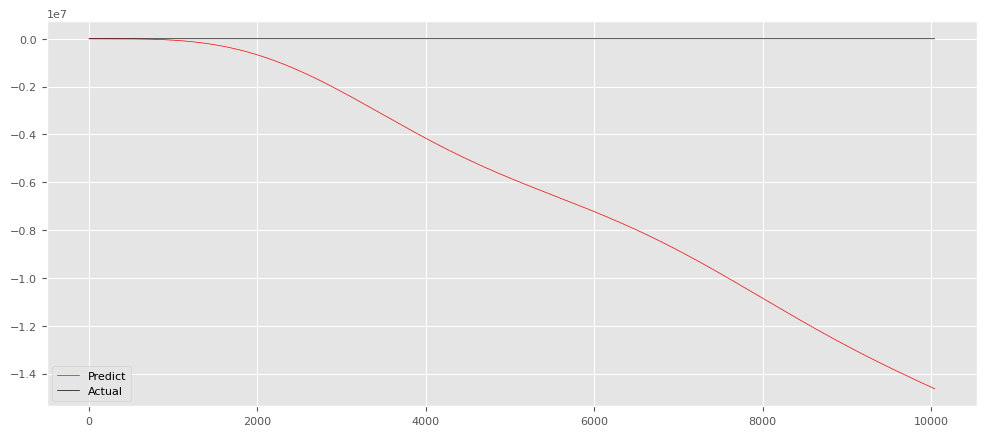

In [9]:
# Sumar las predicciones de los IMFs
imf_eemd_fc = np.sum(imf_arima_forecasts, axis=0)

# Graficar los resultados
plt.plot(imf_eemd_fc, label='Predict', color='r', linewidth=0.5)
plt.plot(test.values, label='Actual', color='k', linewidth=0.5)
plt.legend()
plt.show()

In [10]:
# Evaluación de métricas de error
RMSE_EEMD_ARIMA = mean_squared_error(test, imf_eemd_fc, squared=False)
MAE_EEMD_ARIMA = mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_ARIMA = mean_absolute_percentage_error(test, imf_eemd_fc)

print(f'RMSE = {RMSE_EEMD_ARIMA}')
print(f'MAE = {MAE_EEMD_ARIMA}')
print(f'MAPE = {MAPE_EEMD_ARIMA}')

RMSE = 7609114.286391386
MAE = 6023955.676457521
MAPE = 4.636498084736692e+18


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
